# Q-Learning: Model-Free Reinforcement Learning

We have disscussed both **Policy Iteration** and **Value Iteration**, where we need
a complete model of the environment (transition probabilities and rewards).

However, many real-world problems don't meet these criteria.

In contrast, **Q-learning** is a **model-free** reinforcement learning algorithm that 
learns action-value functions (Q-values) through interaction with the environment, 
without requiring knowledge of the transition dynamics.

**The Q-Learning Algorithm:**

$$q(s,a) \leftarrow q(s,a) + \alpha \left[ r + \gamma \max_{a'} q(s',a') - q(s,a) \right]$$

Where:
- $q(s,a)$: Action-value (expected return from state $s$ taking action $a$)
- $\alpha$: Learning rate (controls how much we update based on new information)
- $r$: Immediate reward received
- $\gamma$: Discount factor (importance of future rewards)
- $s'$: Next state after taking action $a$
- $\max_{a'} q(s',a')$: Maximum q-value in the next state (optimistic estimate)

The term $\left[ r + \gamma \max_{a'} q(s',a') - q(s,a) \right]$ is called the **TD error** (temporal difference error).

Q-learning is one of the **Temporal Difference** (TD) methods, which are a class of model-free reinforcement learning algorithms.
Specifically, it is an **off-policy** method, meaning that we are not following a specific policy while learning,
but instead are learning the optimal policy from the Q-values. However, we can allow some exploration via an
**ε-greedy**-type approach.

We will use the **CartPole** example to illustrate how Q-learning works.

### The CartPole Environment

CartPole is a classic control problem where:
- **Goal**: Balance a pole on a moving cart
- **State**: 4 continuous values (cart position, cart velocity, pole angle, pole angular velocity)
- **Actions**: 2 discrete actions (push left or right)
- **Challenge**: The state space is continuous, but tabular Q-learning requires discrete states

**Our Approach**: Discretize the continuous state space into bins, creating a finite state representation suitable for tabular Q-learning.


In [1]:
"""Import required libraries and create the CartPole environment."""
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

env = gym.make("CartPole-v1")

In [2]:
"""State Space Discretization

CartPole has a continuous 4D state space:
  0: cart position (-4.8 to 4.8)
  1: cart velocity (-inf to inf, practically ±5)
  2: pole angle (-0.418 to 0.418 radians ≈ ±24°)
  3: pole angular velocity (-inf to inf, practically ±5)

We discretize each dimension into bins to create a finite state space.
"""
from typing import List, Tuple
from numpy.typing import NDArray

# Number of bins per dimension (cart_pos, cart_vel, pole_angle, pole_vel)
num_bins: Tuple[int, int, int, int] = (6, 6, 12, 12)

# Observation space bounds
obs_high: NDArray[np.float64] = np.array([4.8, 5.0, 0.418, 5.0])
obs_low: NDArray[np.float64] = -obs_high

def create_bins(
    low: NDArray[np.float64],
    high: NDArray[np.float64],
    bins: Tuple[int, ...]
) -> List[NDArray[np.float64]]:
    """Creates bin edges for discretizing continuous observations.

    Args:
        low: Lower bounds for each dimension.
        high: Upper bounds for each dimension.
        bins: Number of bins for each dimension.

    Returns:
        List of arrays, where each array contains bin edges for that dimension.
    """
    return [np.linspace(low[i], high[i], bins[i] - 1) for i in range(len(bins))]

bins_list: List[NDArray[np.float64]] = create_bins(obs_low, obs_high, num_bins)

def discretize(
    obs: NDArray[np.float64],
    bins_list: List[NDArray[np.float64]]
) -> Tuple[int, ...]:
    """Converts continuous observation to discrete state indices.

    Args:
        obs: Continuous observation vector (length 4).
        bins_list: List of bin edges for each dimension.

    Returns:
        Tuple of bin indices, one per dimension.
    """
    return tuple(int(np.digitize(obs[i], bins_list[i])) for i in range(len(bins_list)))


In [3]:
"""Hyperparameters for Q-Learning

Key parameters that control learning behavior:
- α (alpha): Learning rate - how much we update q-values each step
- γ (gamma): Discount factor - how much we value future rewards
- ε (epsilon): Exploration rate - probability of random action

We use ε-greedy exploration with linear decay.
"""
# Q-learning hyperparameters
alpha: float = 0.1    # Learning rate (typical range: 0.01 - 0.5)
gamma: float = 0.99   # Discount factor (typical range: 0.9 - 0.99)

# Exploration schedule (ε-greedy)
eps_start: float = 1.0   # Initial exploration rate (100% random)
eps_end: float = 0.05    # Final exploration rate (5% random)
eps_decay_episodes: int = 500  # Episodes over which to decay ε

# Training duration
episodes: int = 1000  # Total number of episodes to train

def epsilon(ep: int) -> float:
    """Computes the exploration rate for a given episode.

    Linearly decays from eps_start to eps_end over eps_decay_episodes.

    Args:
        ep: Current episode number.

    Returns:
        Exploration probability for this episode.
    """
    frac = min(1.0, ep / eps_decay_episodes)
    return eps_start * (1 - frac) + eps_end * frac


## Visualizing the Untrained Policy

Before training, let's see how a random policy performs. This provides a baseline for comparison.


In [4]:
"""Demonstrate untrained (random) policy performance."""

def simulate_policy(
    env,
    q_table: NDArray[np.float64],
    num_episodes: int = 5,
    eps: float = 0.0
) -> List[float]:
    """Runs episodes using the given policy.

    Args:
        env: Gymnasium/Gym environment.
        q_table: Learned q-values, i.e., the policy.
        num_episodes: Number of test episodes to run.
        eps: Exploration rate.

    Returns:
        List of episode returns.
    """
    test_returns: List[float] = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        state = np.clip(state, obs_low, obs_high)
        discrete_state: Tuple[int, ...] = discretize(state, bins_list)

        done: bool = False
        episode_return: float = 0.0

        while not done:
            # e-greedy action selection
            if np.random.random() < eps:
                action = env.action_space.sample()
            else:
                action = int(np.argmax(q_table[discrete_state]))

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            next_state = np.clip(next_state, obs_low, obs_high)
            discrete_state = discretize(next_state, bins_list)
            episode_return += reward

        test_returns.append(episode_return)

    return test_returns

# Test a random policy (setting eps to 1.0)
random_q = np.zeros(num_bins + (env.action_space.n,))  # Empty q-table
random_returns = simulate_policy(env, random_q, num_episodes=10, eps=1.0)

print("🎲 Untrained (Random) Policy Performance:")
print(f"   Average return: {np.mean(random_returns):.1f} ± {np.std(random_returns):.1f}")
print(f"   Episodes: {random_returns}")


🎲 Untrained (Random) Policy Performance:
   Average return: 15.8 ± 4.9
   Episodes: [17.0, 8.0, 19.0, 12.0, 18.0, 13.0, 27.0, 12.0, 16.0, 16.0]


## Q-Learning Training

Now we train the agent using Q-learning. Watch how the episode returns improve over time!

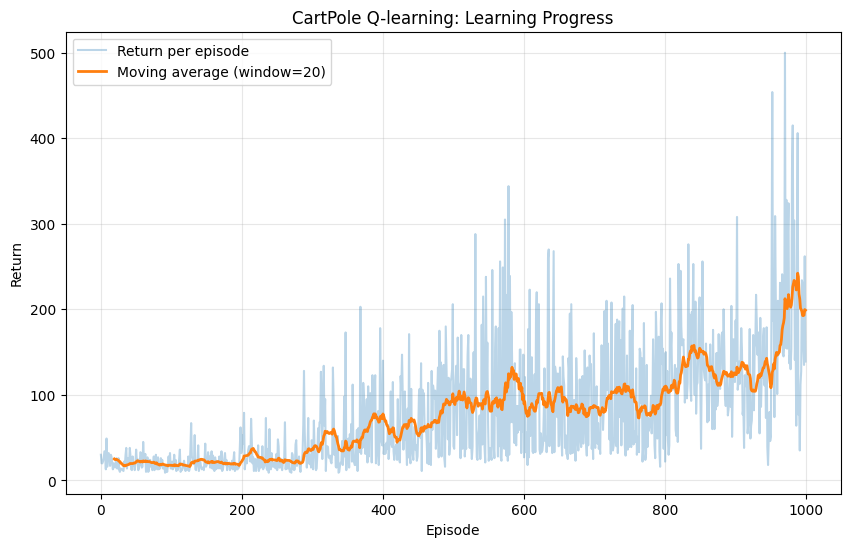

In [5]:
"""Q-Learning Training Loop

This implements the core Q-learning algorithm:
1. Initialize q-table (state-action values)
2. For each episode:
   - Reset environment
   - Select actions using ε-greedy policy
   - Update q-values using temporal difference learning
   - Track episode returns for performance monitoring

The Q-learning update formula:
  q(s,a) ← q(s,a) + α[r + γ max_a' q(s',a') - q(s,a)]
"""
from typing import List

SEED = 42

np.random.seed(SEED)
env.action_space.seed(SEED)

# Initialize q-table: shape = (bins[0], bins[1], bins[2], bins[3], num_actions)
q: NDArray[np.float64] = np.zeros(num_bins + (env.action_space.n,), dtype=float)
episode_returns: List[float] = []  # Track cumulative reward per episode

for episode in range(episodes):
    # Reset environment for new episode
    state, info = env.reset(seed=SEED if episode == 0 else None)

    # Clip observation to valid range and discretize
    state = np.clip(state, obs_low, obs_high)
    discrete_state: Tuple[int, ...] = discretize(state, bins_list)

    done: bool = False
    episode_return: float = 0.0  # Cumulative reward for this episode
    current_eps: float = epsilon(episode)  # Exploration rate for this episode

    while not done:
        # ε-greedy action selection
        if np.random.random() < current_eps:
            action = env.action_space.sample()  # Explore: random action
        else:
            action = int(np.argmax(q[discrete_state]))  # Exploit: best known action

        # Take action, observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Clip and discretize next state
        next_state = np.clip(next_state, obs_low, obs_high)
        discrete_next_state: Tuple[int, ...] = discretize(next_state, bins_list)

        # Q-learning update (off-policy: uses max over next actions)
        td_target: float = reward + (0.0 if done else gamma * np.max(q[discrete_next_state]))
        td_error: float = td_target - q[discrete_state + (action,)]
        q[discrete_state + (action,)] += alpha * td_error

        # Transition to next state
        discrete_state = discrete_next_state
        episode_return += reward

    episode_returns.append(episode_return)

# Plot learning curve
window: int = 20
moving_avg: NDArray[np.float64] = np.convolve(
    episode_returns, np.ones(window) / window, mode="valid"
)

plt.figure(figsize=(10, 6))
plt.plot(episode_returns, alpha=0.3, label="Return per episode")
plt.plot(
    np.arange(window - 1, len(episode_returns)),
    moving_avg,
    linewidth=2,
    label=f"Moving average (window={window})"
)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("CartPole Q-learning: Learning Progress")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Visualizing the Trained Policy

Let's test our learned policy and compare it to the random baseline!


🎓 Trained Policy Performance:
   Average return: 270.2 ± 94.5
   Best episode: 394
   Worst episode: 55

📊 Comparison:
   Random policy: 15.8 ± 4.9
   Trained policy: 270.2 ± 94.5
   Improvement: 254.4 (1610.1%)


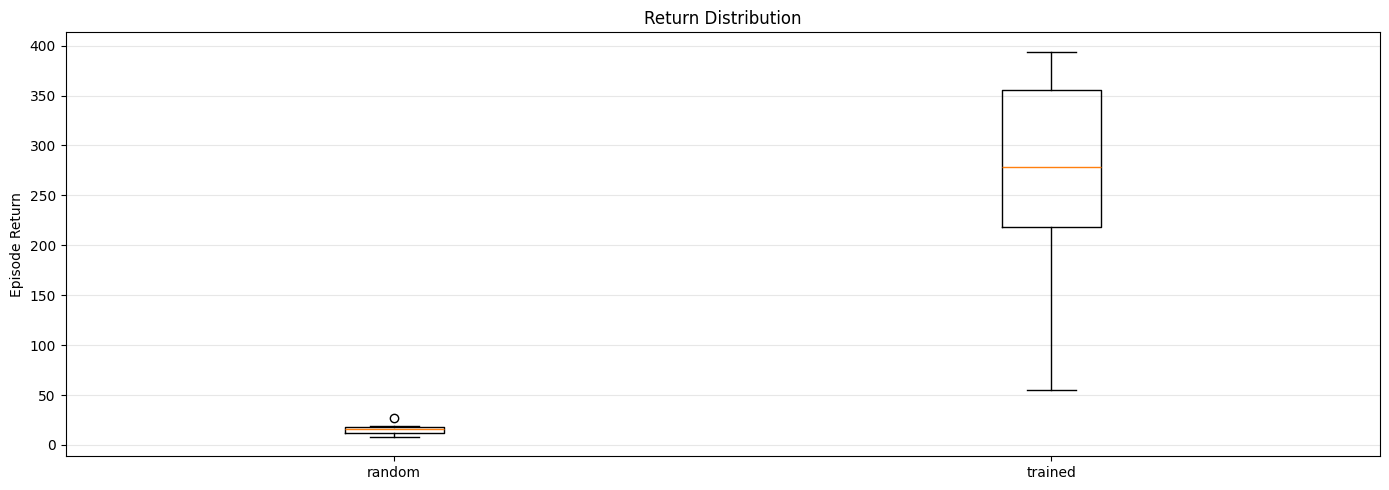

In [6]:
"""Test the trained policy and compare with random baseline."""

# Test trained policy
trained_returns = simulate_policy(env, q, num_episodes=20, eps=0.1)

print("🎓 Trained Policy Performance:")
print(f"   Average return: {np.mean(trained_returns):.1f} ± {np.std(trained_returns):.1f}")
print(f"   Best episode: {max(trained_returns):.0f}")
print(f"   Worst episode: {min(trained_returns):.0f}")

print("\n📊 Comparison:")
print(f"   Random policy: {np.mean(random_returns):.1f} ± {np.std(random_returns):.1f}")
print(f"   Trained policy: {np.mean(trained_returns):.1f} ± {np.std(trained_returns):.1f}")
print(f"   Improvement: {np.mean(trained_returns) - np.mean(random_returns):.1f} ({(np.mean(trained_returns)/np.mean(random_returns) - 1)*100:.1f}%)")

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# Box plot for distribution
ax.boxplot([random_returns, trained_returns], tick_labels=["random", "trained"])
ax.set_ylabel('Episode Return')
ax.set_title('Return Distribution')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Optional: Render Policy Visually

If you want to see the agent in action, you can render episodes. Note: This requires a display and may not work in all environments.


In [7]:
"""Render a single episode with the trained policy."""

def render_policy(trained_policy: NDArray[np.float64] | None = None) -> None:
    """Renders a single episode with the trained policy. If not provided, uses a random policy."""
    render_env = gym.make("CartPole-v1", render_mode="human")

    state, info = render_env.reset()
    state = np.clip(state, obs_low, obs_high)
    discrete_state = discretize(state, bins_list)

    done = False
    total_reward = 0.0

    while not done:
        render_env.render()  # For old gym

        if trained_policy is None:
            q = np.zeros(num_bins + (render_env.action_space.n,))
        else:  # Greedy
            q = trained_policy
        action = int(np.argmax(q[discrete_state]))

        next_state, reward, terminated, truncated, info = render_env.step(action)
        done = terminated or truncated


        next_state = np.clip(next_state, obs_low, obs_high)
        discrete_state = discretize(next_state, bins_list)
        total_reward += reward

    print(f"🎬 Rendered episode return: {total_reward:.0f}")
    render_env.close()

In [8]:
# Animate a random policy
# render_policy()

In [9]:
# Animate the trained policy
# render_policy(q)